In [1]:
import dill as pickle
import numpy as np
import pandas as pd
from datetime import datetime
from generate_sample_U import *
import geopandas as gpd
import os

In [2]:
def save_obj(filename, obj, obj_name):
    path = f"krause-output/"
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    filepath = f"{path}{filename}_{obj_name}.sav"
    pickle.dump(obj, open(filepath, "wb"))

In [3]:
def load_obj(filename, obj_name):
    path = f"krause-output/{filename}_{obj_name}.sav"
    return pickle.load(open(path, 'rb'))

In [4]:
def load_model(filename):
    path = f"../gp-models/GPR-models/ST-SVGP/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    val_df = pickle.load(open(f"{path}_val_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, val_df, scalers

In [5]:
filename = "STSVGP_MODEL_2936"

In [6]:
model, df, train_df, test_df, val_df, scalers = load_model(filename)

In [7]:
S_df, U_df = generate_placement_sets(df, scalers, n=1000, plot=False)

In [8]:
S_df.head()

,code,latitude,longitude,scaled_latitude,scaled_longitude
1,BG1,51.563752,0.177891,1.046959,1.922441
2,BX1,51.465983,0.184877,-0.661768,1.965744
3,HS4,51.492507,-0.257252,-0.198206,-0.774770
6,LH2,51.479234,-0.440531,-0.430184,-1.910814
7,EN4,51.614864,-0.050766,1.940256,0.505123


In [9]:
U_df.head()

,code,latitude,longitude,scaled_latitude,scaled_longitude
0,U_126,51.466667,-0.466667,-0.649824,-2.072816
1,U_135,51.500000,-0.466667,-0.067249,-2.072816
2,U_144,51.533333,-0.466667,0.515325,-2.072816
3,U_153,51.566667,-0.466667,1.097900,-2.072816
4,U_162,51.600000,-0.466667,1.680474,-2.072816


In [10]:
"""
Optimize sensor placements using GP model and sets S and U
"""
def STSVGP_krause(GP, k, S_df, U_df, t_max, t_min=0):
    logs = dict()
    
    A = list()
    A_scores = list()
    for i in range(1, k+1):
        # log_i = []

        y_star_code = None
        delta_y_star = None

        S_diff_A = [site for site in S_df['code'] if site not in A]
        for j, y in enumerate(S_diff_A):
            print(f"k={i}, {j}/{len(S_diff_A)}")
            delta_ys = []
            
            for t in range(t_min, t_max+1):
                S_t_df = S_df.copy()
                S_t_df["t"] = t
                U_t_df = U_df.copy()
                U_t_df["t"] = t
                A_t_df = S_t_df.loc[S_t_df['code'].isin(A)]
                
                y_df = S_t_df.loc[S_t_df['code'] == y]
                yA_df = y_df.append(A_t_df)

                yA_t = np.array([[t]])
                yA_R = np.tile(yA_df[["scaled_latitude", "scaled_longitude"]].values, [yA_t.shape[0], 1, 1])
                yA_mean, yA_cov = GP.cov(X=yA_t, R=yA_R)
                
                if len(A) == 0:
                    y_var = np.square(yA_cov.item())
                    numerator = y_var
                else:
                    y_var = np.square(yA_cov[0][0])
                    yA_cov_row = yA_cov[0, 1:]
                    AA_cov_mat = yA_cov[1:, 1:]
                    numerator = y_var - yA_cov_row@np.linalg.inv(AA_cov_mat)@yA_cov_row.T

                A_y = A + [y]
                S_diff_A_y = [site for site in S_t_df['code'] if site not in A_y]
                A_bar_df = S_t_df.loc[S_t_df['code'].isin(S_diff_A_y)]#.append(U_t_df)
                yA_bar_df = y_df.append(A_bar_df)

                yA_bar_t = np.array([[t]])
                yA_bar_R = np.tile(yA_bar_df[["scaled_latitude", "scaled_longitude"]].values, [yA_bar_t.shape[0], 1, 1])

                yA_bar_mean, yA_bar_cov = GP.cov(X=yA_bar_t, R=yA_bar_R)

                yA_bar_cov_row = yA_bar_cov[0, 1:]
                AA_bar_cov_mat = yA_bar_cov[1:, 1:]
                # print('y_var', y_var)
                # print('AA_bar_cov_mat', AA_bar_cov_mat.shape)
                # print('yA_bar_cov_row', yA_bar_cov_row.shape)
                denominator = y_var - yA_bar_cov_row@np.linalg.inv(AA_bar_cov_mat)@yA_bar_cov_row.T

                delta_y = numerator/denominator
                delta_ys.append(delta_y)
            
            avg_delta_y = np.mean(delta_ys)
                
            if not y_star_code:
                y_star_code = y
                delta_y_star = avg_delta_y
            elif avg_delta_y > delta_y_star:
                y_star_code = y
                delta_y_star = avg_delta_y

                # log_i.append([y, delta_y])
        A.append(y_star_code)
        A_scores.append(delta_y_star)
        # logs[i] = log_i
        
    A_df = pd.DataFrame({"site": A, "site_score": A_scores, "order": list(range(1, k+1))})
    return A_df, logs

In [11]:
A_df, logs = STSVGP_krause(model, 25, S_df, U_df, 0)

k=1, 0/103
k=1, 1/103
k=1, 2/103
k=1, 3/103
k=1, 4/103
k=1, 5/103
k=1, 6/103
k=1, 7/103
k=1, 8/103
k=1, 9/103
k=1, 10/103
k=1, 11/103
k=1, 12/103
k=1, 13/103
k=1, 14/103
k=1, 15/103
k=1, 16/103
k=1, 17/103
k=1, 18/103
k=1, 19/103
k=1, 20/103
k=1, 21/103
k=1, 22/103
k=1, 23/103
k=1, 24/103
k=1, 25/103
k=1, 26/103
k=1, 27/103
k=1, 28/103
k=1, 29/103
k=1, 30/103
k=1, 31/103
k=1, 32/103
k=1, 33/103
k=1, 34/103
k=1, 35/103
k=1, 36/103
k=1, 37/103
k=1, 38/103
k=1, 39/103
k=1, 40/103
k=1, 41/103
k=1, 42/103
k=1, 43/103
k=1, 44/103
k=1, 45/103
k=1, 46/103
k=1, 47/103
k=1, 48/103
k=1, 49/103
k=1, 50/103
k=1, 51/103
k=1, 52/103
k=1, 53/103
k=1, 54/103
k=1, 55/103
k=1, 56/103
k=1, 57/103
k=1, 58/103
k=1, 59/103
k=1, 60/103
k=1, 61/103
k=1, 62/103
k=1, 63/103
k=1, 64/103
k=1, 65/103
k=1, 66/103
k=1, 67/103
k=1, 68/103
k=1, 69/103
k=1, 70/103
k=1, 71/103
k=1, 72/103
k=1, 73/103
k=1, 74/103
k=1, 75/103
k=1, 76/103
k=1, 77/103
k=1, 78/103
k=1, 79/103
k=1, 80/103
k=1, 81/103
k=1, 82/103
k=1, 83/103
k=

In [12]:
save_obj(filename, A_df, "A_df")

In [19]:
A_df.head()

,site,site_score,order
0,CT1,3.361238,1
1,WA9,2.877045,2
2,BL0,1.845265,3
3,RI2,1.805667,4
4,LW2,1.756465,5


In [21]:
site_coords_path = "../data-collection/LAQN_API_data/site_coordinates.csv"
header_list = ["site", "latitude", "longitude"]
plot_df = pd.read_csv(site_coords_path, names=header_list)
plot_df = A_df.merge(plot_df, on="site")

In [23]:
mutual_info_df = plot_df.copy()

In [26]:
mutual_info_df.head()

,site,site_score,order,latitude,longitude
0,CT1,3.361238,1,51.511491,-0.095807
1,WA9,2.877045,2,51.465033,-0.215825
2,BL0,1.845265,3,51.522287,-0.125848
3,RI2,1.805667,4,51.476168,-0.230427
4,LW2,1.756465,5,51.474954,-0.039641


In [27]:
save_obj(filename, mutual_info_df, "mutual_info_df")

In [15]:
map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
# map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp"
map_df = gpd.read_file(map_filepath)
map_df = map_df.to_crs("EPSG:4326")
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-0.33066 51.32901, -0.33057 51.32909..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-0.06399 51.31864, -0.06405 51.31861..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((0.01216 51.29960, 0.01199 51.29979, ..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-0.24454 51.48870, -0.24466 51.48868..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-0.41181 51.53408, -0.41186 51.53413..."


In [16]:
def plot_uncertainty_contour(model, inducing_points=False, full=True, grid_size=50):
    grid_size = 50
    # t_plot = np.linspace(df['t'].min(), df['t'].max(), num=df['t'].max()-df['t'].min()+1).reshape(-1, 1)
    lat_min, lat_max = 51.279, 51.7
    lon_min, lon_max = -0.533, 0.350

    t_plot = np.linspace(0, 9, num=10).reshape(-1, 1)
    lat_plot = np.linspace(lat_min, lat_max, num=grid_size).reshape(-1, 1)
    lon_plot = np.linspace(lon_min, lon_max, num=grid_size).reshape(-1, 1)
    LAT, LON = np.meshgrid(lat_plot, lon_plot)

    scaled_lat_plot = scalers['latitude'].transform(lat_plot).flatten()
    scaled_lon_plot = scalers['longitude'].transform(lon_plot).flatten()
    r1_plot, r2_plot = [], []
    for i in range(grid_size):
        for j in range(grid_size):
            r1_plot.append([scaled_lat_plot[i]])
            r2_plot.append([scaled_lon_plot[j]])
    r1_plot, r2_plot = np.array(r1_plot), np.array(r2_plot)
    R_plot = np.tile(np.hstack((r1_plot, r2_plot)), [t_plot.shape[0], 1, 1])

    pred_mean, pred_var = model.predict_y(X=t_plot, R=R_plot)

    pred_mean_plot = np.mean(pred_mean, axis=0).reshape(grid_size, grid_size)
    pred_var_plot = np.mean(pred_var, axis=0).reshape(grid_size, grid_size)

    if full:
        plt.contourf(LON, LAT, pred_var_plot)
    else:
        plt.contour(LON, LAT, pred_var_plot)
    plt.colorbar()

    if inducing_points:
        z_opt = model.kernel.z.value
        z_lat = scalers['latitude'].inverse_transform(z_opt[:, 0].reshape(-1, 1))
        z_lon = scalers['longitude'].inverse_transform(z_opt[:, 1].reshape(-1, 1))
        plt.scatter(z_lon, z_lat, label="inducing points", color="purple")
        plt.legend()

<AxesSubplot:>

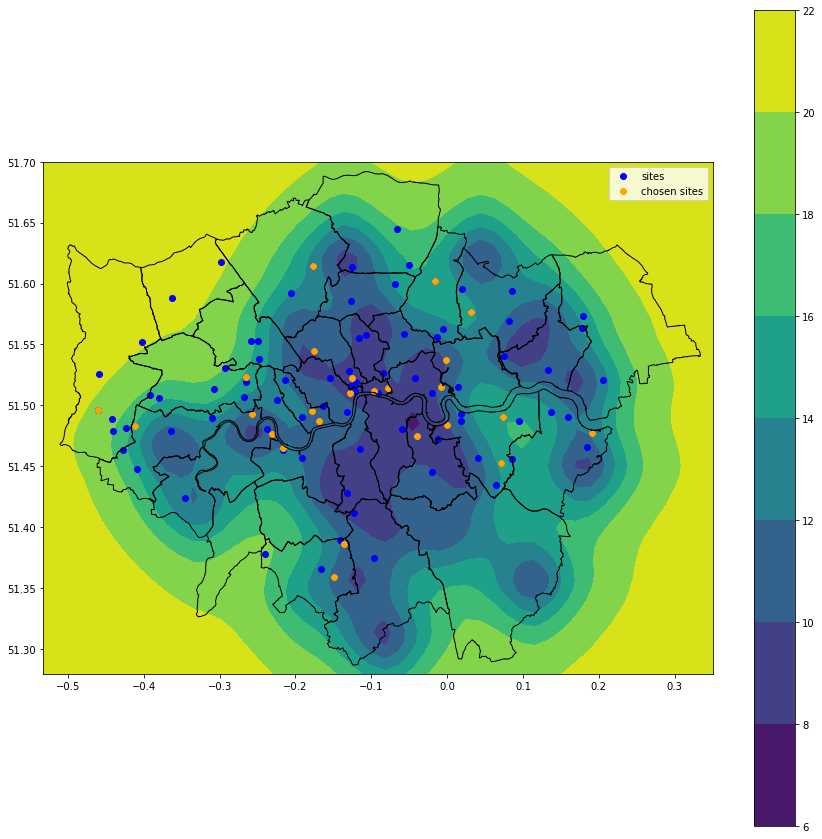

In [17]:
fig, ax = plt.subplots(figsize=(15,15))

plot_uncertainty_contour(model)

plt.scatter(S_df["longitude"], S_df["latitude"], label="sites", color="blue")
plt.scatter(plot_df["longitude"], plot_df["latitude"], label="chosen sites", color="orange")
plt.legend()
# plt.scatter(sites_df.loc[sites_df['code'] == "HK6", 'longitude'].item(), sites_df.loc[sites_df['code'] == "HK6", 'latitude'].item(), label="HK6 (validation site)", color="red")

#plt.scatter(z_lon, z_lat, label="inducing points", color="purple")
#plt.legend()

ax.set_facecolor('white')
map_df.plot(ax=ax, color="None")

In [149]:
"""
Optimize sensor placements using GP model and sets S and U
"""
def krause(GP, k, S_df, U_df, x_features, t_max, t_min=0):
    logs = dict()
    
    A = list()
    A_scores = list()
    for i in range(1, k+1):
        # log_i = []

        y_star_code = None
        delta_y_star = None

        S_diff_A = [site for site in S_df['code'] if site not in A]
        for y in S_diff_A:
            delta_ys = []
            
            for t in range(t_min, t_max+1):
                S_t_df = S_df.copy()
                S_t_df["t"] = t
                U_t_df = U_df.copy()
                U_t_df["t"] = t
                A_t_df = S_t_df.loc[S_t_df['code'].isin(A)]
                
                y_df = S_t_df.loc[S_t_df['code'] == y]
                yA_df = y_df.append(A_t_df)

                yA_mean, yA_cov = GP.predict(yA_df[x_features], return_cov=True)
                
                y_var = np.square(yA_cov[0][0])
                if len(A) == 0:
                    numerator = y_var
                else:
                    yA_cov_row = yA_cov[0, 1:]
                    AA_cov_mat = yA_cov[1:, 1:]
                    numerator = y_var - yA_cov_row@np.linalg.inv(AA_cov_mat)@yA_cov_row.T

                A_y = A + [y]
                S_diff_A_y = [site for site in S_t_df['code'] if site not in A_y]
                A_bar_df = S_t_df.loc[S_t_df['code'].isin(S_diff_A_y)]#.append(U_t_df)
                yA_bar_df = y_df.append(A_bar_df)

                yA_bar_mean, yA_bar_cov = GP.predict(yA_bar_df[x_features], return_cov=True)

                yA_bar_cov_row = yA_bar_cov[0, 1:]
                AA_bar_cov_mat = yA_bar_cov[1:, 1:]
                # print('y_var', y_var)
                # print('AA_bar_cov_mat', AA_bar_cov_mat.shape)
                # print('yA_bar_cov_row', yA_bar_cov_row.shape)
                denominator = y_var - yA_bar_cov_row@np.linalg.inv(AA_bar_cov_mat)@yA_bar_cov_row.T

                delta_y = numerator/denominator
                delta_ys.append(delta_y)
            
            avg_delta_y = np.mean(delta_ys)
                
            if not y_star_code:
                y_star_code = y
                delta_y_star = avg_delta_y
            elif avg_delta_y > delta_y_star:
                y_star_code = y
                delta_y_star = avg_delta_y

        print(yA_cov)
                # log_i.append([y, delta_y])
        A.append(y_star_code)
        A_scores.append(delta_y_star)
        # logs[i] = log_i
        
    A_df = pd.DataFrame({"site": A, "site_score": A_scores, "order": list(range(1, k+1))})
    return A_df, logs

In [ ]:
"""
Optimize sensor placements using GP model and sets S and U

def krause2(GP, k, S_df, U_df, x_features, t_max, t_min=0):
    # logs = dict()
    
    A = list()
    A_scores = list()
    for i in range(1, k+1):
        # log_i = []
        
        A_df = S_df.loc[S_df['code'].isin(A)]
        y_star_code = None
        y_star = None

        S_diff_A = [site for site in S_df['code'] if site not in A]
        for y in S_diff_A:
            for t in range(t_min, t_max+1):
                S_t_df = S_df.copy()
                S_t_df["t"] = t
                U_t_df = U_df.copy()
                U_t_df["t"] = t
                
                y_df = S_df.loc[S_df['code'] == y]
                yA_df = y_df.append(A_df)

                yA_mean, yA_cov = GP.predict(yA_df[x_features], return_cov=True)

                y_var = yA_cov[0][0]
                if len(A) == 0:
                    numerator = y_var
                else:
                    yA_cov_row = yA_cov[0, 1:]
                    AA_cov_mat = yA_cov[1:, 1:]
                    numerator = y_var - yA_cov_row@np.linalg.inv(AA_cov_mat)@yA_cov_row.T

                A_y = A + [y]
                S_diff_A_y = [site for site in S_df['code'] if site not in A_y]
                A_bar_df = S_df.loc[S_df['code'].isin(S_diff_A_y)]#.append(U_df)
                yA_bar_df = y_df.append(A_bar_df)

                yA_bar_mean, yA_bar_cov = GP.predict(yA_bar_df[x_features], return_cov=True)

                yA_bar_cov_row = yA_bar_cov[0, 1:]
                AA_bar_cov_mat = yA_bar_cov[1:, 1:]
                denominator = y_var - yA_bar_cov_row@np.linalg.inv(AA_bar_cov_mat)@yA_bar_cov_row.T

                delta_y = numerator/denominator
                if not y_star_code:
                    y_star_code = y
                    y_star = delta_y
                elif delta_y > y_star:
                    y_star_code = y
                    y_star = delta_y

                # log_i.append([y, delta_y])
        A.append(y_star_code)
        A_scores.append(y_star)
        # logs[i] = log_i
        
    A_df = pd.DataFrame({"site": A, "site_score": A_scores, "order": list(range(1, k+1))})
    return A_df, logs
"""

In [154]:
A_df_new, logs = krause(GP=model, k=5, S_df=S_df_dirty, U_df=U_df_dirty, x_features=["scaled_latitude", "scaled_longitude", "t"], t_max=1)

[[180.58749425]]
[[1.80587494e+02 1.23450152e-02]
 [1.23450152e-02 2.02243538e+01]]
[[1.80587494e+02 5.50845036e-01 1.23450152e-02]
 [5.50845036e-01 4.95791117e+02 6.03171562e-02]
 [1.23450152e-02 6.03171562e-02 2.02243538e+01]]
[[1.80587494e+02 7.45409505e-01 5.50845036e-01 1.23450152e-02]
 [7.45409505e-01 5.99693297e+02 6.02805027e+00 7.96320471e-02]
 [5.50845036e-01 6.02805027e+00 4.95791117e+02 6.03171562e-02]
 [1.23450152e-02 7.96320471e-02 6.03171562e-02 2.02243538e+01]]
[[1.80587494e+02 7.45409505e-01 5.50845036e-01 8.10503893e-01
  1.23450152e-02]
 [7.45409505e-01 5.99693297e+02 6.02805027e+00 7.93066544e+00
  7.96320471e-02]
 [5.50845036e-01 6.02805027e+00 4.95791117e+02 6.45663440e+00
  6.03171562e-02]
 [8.10503893e-01 7.93066544e+00 6.45663440e+00 6.97828350e+02
  8.72995463e-02]
 [1.23450152e-02 7.96320471e-02 6.03171562e-02 8.72995463e-02
  2.02243538e+01]]


In [155]:
A_df_new

,site,site_score,order
0,KC7,1.032824,1
1,BX9,1.004165,2
2,EA0,1.003503,3
3,MY7,1.002092,4
4,BQ7,1.001600,5


In [182]:
def plot_krause_df(A, S_df, U_df):
    cols = ["code", "latitude", "longitude", "Status", "k"]
    df = pd.DataFrame(columns=cols)
    k = len(A)
    for i in range(1, k+1):
        chosen_sites = A.site
        print(chosen_sites)
        df_i = S_df.copy()
        df_i["Status"] = "Not chosen"
        df_i["k"] = i
        for a in chosen_sites:
            print("chosen site ", a)
            df_i.loc[df_i["code"] == a, "Status"] = "Chosen"
        df = df.append(df_i)
        
    U_copy = U_df.copy()
    U_copy["Status"] = "U"
    U_copy["k"] = 0
    df = df.append(U_copy)
    return df

In [183]:
plot_df = plot_krause_df(A_df_new, S_df, U_df)

0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7
0    KC7
1    BX9
2    EA0
3    MY7
4    BQ7
Name: site, dtype: object
chosen site  KC7
chosen site  BX9
chosen site  EA0
chosen site  MY7
chosen site  BQ7


In [184]:
plot_df

,code,latitude,longitude,Status,k,scaled_latitude,scaled_longitude,code_x,code_y
0,BX5,51.478802,0.133874,Not chosen,1,-0.432117,1.733068,NaN,NaN
1,BG1,51.563752,0.177891,Not chosen,1,1.011796,2.019482,NaN,NaN
2,BX1,51.465983,0.184877,Not chosen,1,-0.650006,2.064939,NaN,NaN
3,HS4,51.492507,-0.257252,Not chosen,1,-0.199175,-0.811933,NaN,NaN
4,VS1,51.499245,-0.131285,Not chosen,1,-0.084647,0.007715,NaN,NaN
...,...,...,...,...,...,...,...,...,...
985,U_3392,51.535354,0.292929,U,0,0.529099,2.768020,NaN,NaN
986,U_3456,51.545455,0.292929,U,0,0.700789,2.768020,NaN,NaN
987,U_3520,51.555556,0.292929,U,0,0.872479,2.768020,NaN,NaN
988,U_3510,51.545455,0.313131,U,0,0.700789,2.899472,NaN,NaN


In [212]:
import plotly.express as px
import geopandas as gpd

In [218]:
london_wards = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
london_wards = london_wards.to_crs("EPSG:4326")
london_wards.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30846 51.37586, -0.30834 51.37606..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26990 51.38845, -0.26975 51.38838..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24662 51.39921, -0.24672 51.39921..."


In [237]:
fig = px.scatter_mapbox(plot_df,
lat='latitude',
lon='longitude', 
color="Status",
#animation_frame="k",
#animation_group="SiteCode",
width=1000, 
height=600,
zoom=10,
text="code"
)
px.line_mapbox(london_wards, lat=london_wards)

fig.update_traces(marker=dict(size=8), selector=dict(mode='markers'))
fig.update_layout(mapbox_style="carto-positron", margin = dict(l = 0, r = 0, t = 10, b = 0))

fig.show(renderer="notebook")

ValueError: The truth value of a GeoDataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<AxesSubplot:>

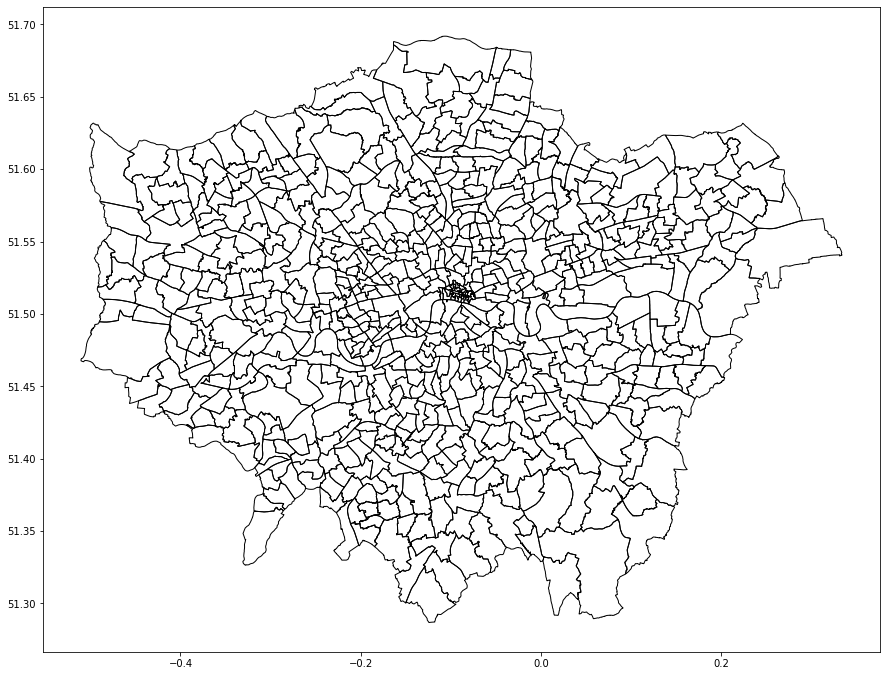

In [213]:
london_wards = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
london_wards = london_wards.to_crs("EPSG:4326")
london_wards.head()

fig, ax = plt.subplots(figsize=(15,15))
ax.set_facecolor('white')
london_wards.plot(ax=ax, color="None")

In [247]:
import folium
import datetime

def save_folium_map(data_df, pollutant, layer_title, date_today, mapping_directory):
    '''
    Save map to interactive html map file using the Folium library.
    
    :param: data_df: dataframe including the training / validation datasets for the gp model

    '''
    
    # import London burough shapefile as geopandas dataframe
    london_gdf = gpd.read_file("../data-collection/statistical-gis-boundaries-london/ESRI/London_Ward.shp")
    print(london_gdf.head())
    
    # create folium map of buroughs
    london_center = [51.507602, -0.127816]
    m = folium.Map(location=london_center, zoom_start=10, tiles='cartodb positron')

    london_gdf.explore(
        m=m,
        # column="NAME", # make choropleth based on "BoroName" column
        color="lightgray",
        tooltip="NAME", # show "BoroName" value in tooltip (on hover)
        popup=True, # show all values in popup (on click)
        tiles="CartoDB positron", # use "CartoDB positron" tiles
        cmap="Set1", # use "Set1" matplotlib colormap
        legend=False, # show legend on the map
        style_kwds=dict(color="black", weight=3, opacity=0.2) # use black outline
    )

    # convert data points df to geopandas dataframe
    U_df = data_df.loc[data_df.Status=='U']
    print(U_df)
    chosen_df = data_df.loc[data_df.Status=='Chosen']
    unchosen_df = data_df.loc[data_df.Status=='Not chosen']

    U_geodf = gpd.GeoDataFrame(
        U_df, geometry=gpd.points_from_xy(U_df.longitude, U_df.latitude), crs="EPSG:4326")
    print(U_geodf)
    chosen_geodf = gpd.GeoDataFrame(
        chosen_df, geometry=gpd.points_from_xy(chosen_df.longitude, chosen_df.latitude))
    unchosen_geodf = gpd.GeoDataFrame(
        unchosen_df, geometry=gpd.points_from_xy(unchosen_df.longitude, unchosen_df.latitude))
    
    # add geodataframe of data to folium map
    geo_dfs = [U_geodf, chosen_geodf, unchosen_geodf]
    status = ['U', 'Chosen', 'Not Chosen']
    colors = ['grey', 'red', 'blue']
    for i in range(len(geo_dfs)):
        geo_df = geo_dfs[i]
        geo_df.explore(
            m=m, # pass the map object
            marker_kwds=dict(radius=3, fill=True), # make marker radius 10px with fill
            # column=pollutant, # make choropleth based on {pollutant} column
            popup=True,
            tooltip=["code"], # show "name" column in the tooltip
            tooltip_kwds=dict(labels=True), # do not show column label in the tooltip
            name=status[i], # name of the layer in the map 
            legend_kwds={'label': pollutant + " Concentration",
                            'orientation': "horizontal"},
            legend=True,
            color = colors[i]
        )

    # add base map features
    folium.LayerControl().add_to(m)  # use folium to add layer control

    # Save map to mapping directory
    # as HTML file
    map_name = layer_title + "_"+ date_today
    print("Saving map to: ", map_name)
    m.save(mapping_directory + map_name + ".html")

In [248]:
save_path = f"../gp-models/GPR_figures/{model_name}/"
map_title = "London_Wards_Placements"
save_folium_map(plot_df, pollutant='N02', layer_title=map_title, date_today=datetime.datetime.now().strftime("%m-%d-%Y"), mapping_directory=save_path)
    

                     NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0       Chessington South  E05000405   755.173         0.0  E09000021   
1  Tolworth and Hook Rise  E05000414   259.464         0.0  E09000021   
2              Berrylands  E05000401   145.390         0.0  E09000021   
3               Alexandra  E05000400   268.506         0.0  E09000021   
4                Beverley  E05000402   187.821         0.0  E09000021   

                BOROUGH  POLY_ID  \
0  Kingston upon Thames    50840   
1  Kingston upon Thames   117160   
2  Kingston upon Thames    50449   
3  Kingston upon Thames    50456   
4  Kingston upon Thames   117161   

                                            geometry  
0  POLYGON ((516401.600 160201.800, 516407.300 16...  
1  POLYGON ((517829.600 165447.100, 517837.100 16...  
2  POLYGON ((518107.500 167303.400, 518114.300 16...  
3  POLYGON ((520480.000 166909.800, 520490.700 16...  
4  POLYGON ((522071.000 168144.900, 522063.900 16...  
       code   

In [25]:
A_df_new

,site,site_score,order
0,EN1,1.009986,1
1,LB6,1.009424,2
2,GR7,1.008785,3
3,EN7,1.008540,4
4,TH4,1.008030,5


In [23]:
A_df_new, logs = krause(model, 5, S_df, U_df, ["scaled_latitude", "scaled_longitude", "t"], 0)

In [30]:
A_df_new_2, logs = krause(model, 5, S_df, U_df, ["scaled_latitude", "scaled_longitude", "t"], 0)

[[2.6900533e-08]]
[[2.69009511e-08 8.95983576e-14]
 [8.95983576e-14 2.69008914e-08]]
[[2.69009511e-08 8.95983576e-14 0.00000000e+00]
 [8.95983576e-14 2.69008914e-08 2.98661192e-14]
 [0.00000000e+00 2.98661192e-14 2.69011303e-08]]
[[ 2.69009511e-08  8.95983576e-14 -2.98661192e-14  0.00000000e+00]
 [ 8.95983576e-14  2.69008914e-08 -8.95983576e-14  2.98661192e-14]
 [-2.98661192e-14 -8.95983576e-14  2.69012498e-08  2.98661192e-14]
 [ 0.00000000e+00  2.98661192e-14  2.98661192e-14  2.69011303e-08]]
[[ 2.69009511e-08  8.95983576e-14 -2.98661192e-14 -2.98661192e-14
   0.00000000e+00]
 [ 8.95983576e-14  2.69008914e-08  0.00000000e+00 -8.95983576e-14
   2.98661192e-14]
 [-2.98661192e-14  0.00000000e+00  2.69010109e-08 -2.98661192e-14
  -2.98661192e-14]
 [-2.98661192e-14 -8.95983576e-14 -2.98661192e-14  2.69012498e-08
   2.98661192e-14]
 [ 0.00000000e+00  2.98661192e-14 -2.98661192e-14  2.98661192e-14
   2.69011303e-08]]


In [31]:
A_df_new_2

,site,site_score,order
0,EN1,1.009986,1
1,LB6,1.009424,2
2,GR7,1.008785,3
3,EN7,1.008540,4
4,TH4,1.008030,5
